# Tutorial: Analyze Functional Dependencies in a Power BI Sample Dataset

In this tutorial, you'll build upon the prior work of a Power BI analyst that's preserved in the form of datasets. Using SemPy in the Fabric data science environment, you'll analyze functional dependencies that exist in columns of a DataFrame. Your analysis will help you discover non-trivial issues with data quality in order to gain more accurate insights.


### In this tutorial, you learn how to:
- Apply domain knowledge to formulate hypotheses about functional dependencies in a dataset;
- Get familiarized with components of Semantic Link's Python library ([SemPy](https://learn.microsoft.com/en-us/python/api/semantic-link-sempy)) that supports integration with Power BI and helps to automate data quality analysis. These components include:
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information;
    - Useful functions for pulling Power BI datasets from a Fabric workspace into your notebook;
    - Useful functions that automate the evaluation of hypothesis about functional dependencies and that identify violations of relationships in your datasets.

### Prerequisites

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Select **Workspaces** from the left navigation pane to find and select your workspace. This workspace becomes your current workspace.
* Download the _Customer Profitability Sample.pbix_ dataset from the [fabric-samples GitHub repository](https://github.com/microsoft/fabric-samples/blob/09cb40f1ffe0a7cfec67ec0ba2fcfdc95ba750a8/docs-samples/data-science/datasets/Customer%20Profitability%20Sample.pbix) and upload it to your workspace.
* Open your notebook. You have two options:
    * [Import this notebook into your workspace](https://learn.microsoft.com/en-us/fabric/data-engineering/how-to-use-notebook#import-existing-notebooks). You can import from the Data Science homepage.
    * Alternatively, you can create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.
* In the Lakehouse explorer section of your notebook, add a new or existing lakehouse to your notebook. For more information on how to add a lakehouse, see [Attach a lakehouse to your notebook](https://learn.microsoft.com/en-us/fabric/data-science/tutorial-data-science-prepare-system#attach-a-lakehouse-to-the-notebooks).

## Set up the notebook

In this section, you'll set up a notebook environment with the necessary modules and data.

First, install `SemPy` from PyPI using pip magic command:

In [1]:
%pip install semantic-link

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 158.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.4/754.4 kB 156.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 179.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 131.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 153.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 164.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 186.9 MB/s eta 0:00:00

[notice] A

Then, perform necessary imports of modules that will be needed later on:

In [2]:
import sempy.fabric as fabric

from sempy.dependencies import plot_dependency_metadata

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 9, Finished, Available)

## Load and preprocess data

This tutorial uses a standard Power BI sample dataset [Customer Profitability Sample.pbix](https://github.com/microsoft/fabric-samples/tree/09cb40f1ffe0a7cfec67ec0ba2fcfdc95ba750a8/docs-samples/data-science/datasets). For a description of the dataset, see [Customer Profitability sample for Power BI](https://learn.microsoft.com/en-us/power-bi/create-reports/sample-customer-profitability).

Load the Power BI data into FabricDataFrames, using SemPy's ``read_table`` function:

In [4]:
dataset = "Customer Profitability Sample"
customer = fabric.read_table(dataset, "Customer")
customer.head()

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 11, Finished, Available)

Customer Country/Region                     Name         City  Postal Code  \
0      1023             US         Spade and Archer       Irving        75038   
1     10000             US               Globo-Chem      Chicago        60601   
2     10001             US  SNC Directly to America  Westchester        60154   
3     10002             US                      GHG        Plano        75024   
4     10003             US           ABC Helicopter   Fort Worth        76177   

  State  Industry ID  
0    TX           31  
1    IL           30  
2    IL           30  
3    TX           13  
4    TX           34

Load the 'State' table into a FabricDataFrame:

In [5]:
state = fabric.read_table(dataset, "State")
state.head()

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 12, Finished, Available)

StateCode    State Region
0        AK   ALASKA   WEST
1        FL  FLORIDA   EAST
2        GA  GEORGIA   EAST
3        HI   HAWAII   WEST
4        IA     IOWA  NORTH

While the output looks like a pandas DataFrame, we actually initialized a data structure called a ``FabricDataFrame`` that supports some useful operations on top of pandas.

In [6]:
type(customer)

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 13, Finished, Available)

sempy.fabric._dataframe._fabric_dataframe.FabricDataFrame

Join the `Customer` and `State` tables:

In [7]:
customer_state_df = customer.merge(state, left_on="State", right_on="StateCode",  how='left')
customer_state_df.head()

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 14, Finished, Available)

Customer Country/Region                     Name         City  Postal Code  \
0      1023             US         Spade and Archer       Irving        75038   
1     10000             US               Globo-Chem      Chicago        60601   
2     10001             US  SNC Directly to America  Westchester        60154   
3     10002             US                      GHG        Plano        75024   
4     10003             US           ABC Helicopter   Fort Worth        76177   

  State_x  Industry ID StateCode   State_y Region  
0      TX           31        TX     TEXAS  SOUTH  
1      IL           30        IL  ILLINOIS  NORTH  
2      IL           30        IL  ILLINOIS  NORTH  
3      TX           13        TX     TEXAS  SOUTH  
4      TX           34        TX     TEXAS  SOUTH

## Identify functional dependencies

A functional dependency manifests itself as a one-to-many relationship between the values in two (or more) columns within a DataFrame (which does not occur if the dataset adheres to 3rd normal form). These relationships can be instrumental for automatic detection of data quality problems. 

Run SemPy's ``find_dependencies`` function on the merged dataframe to identify any existing functional dependencies between values in the columns:

In [8]:
dependencies = customer_state_df.find_dependencies()
dependencies

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 15, Finished, Available)

Determinant             Dependent  Conditional Entropy  \
0              Customer                  Name             0.000000   
1              Customer           Postal Code             0.000000   
2              Customer                  City             0.000000   
3              Customer               State_x             0.000000   
4              Customer           Industry ID             0.000000   
5                  Name        Country/Region             0.004239   
6               State_x  [StateCode, State_y]             0.000000   
7               State_x        Country/Region             0.000000   
8  [StateCode, State_y]                Region             0.000000   

   Determinant Unique Count  Dependent Unique Count  Determinant Null Count  \
0                       327                     303                       0   
1                       327                     208                       0   
2                       327                     188                       0   
3                       327                      37                       0   
4                       327                      32                       0   
5                       303                       4                       0   
6                        37                      34                       0   
7                        37                       4                       0   
8                        34                       6                      13   

   Dependent Null Count  
0                     0  
1                    50  
2                     0  
3                     0  
4                     0  
5                     0  
6                    13  
7                     0  
8                    13

Visualize the identified dependencies by using SemPy's ``plot_dependency_metadata`` function:

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 16, Finished, Available)

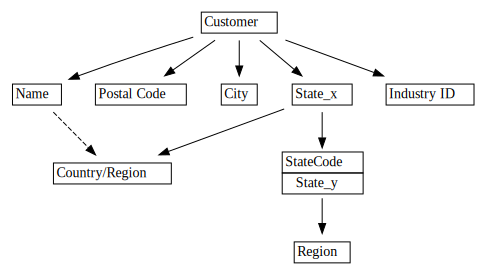

In [9]:
plot_dependency_metadata(dependencies)

As expected, the functional dependencies graph shows that *Customer* determines some columns like *City*, *Postal Code*, and *Name*. 

Surprisingly, the graph doesn't show a functional dependency between _City_ and _Postal Code_, probably because there are many violations in the relationships between the columns. You can use SemPy's ``plot_dependency_violations`` function to visualize violations of dependencies between specific columns.

## Explore data for quality issues

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 17, Finished, Available)

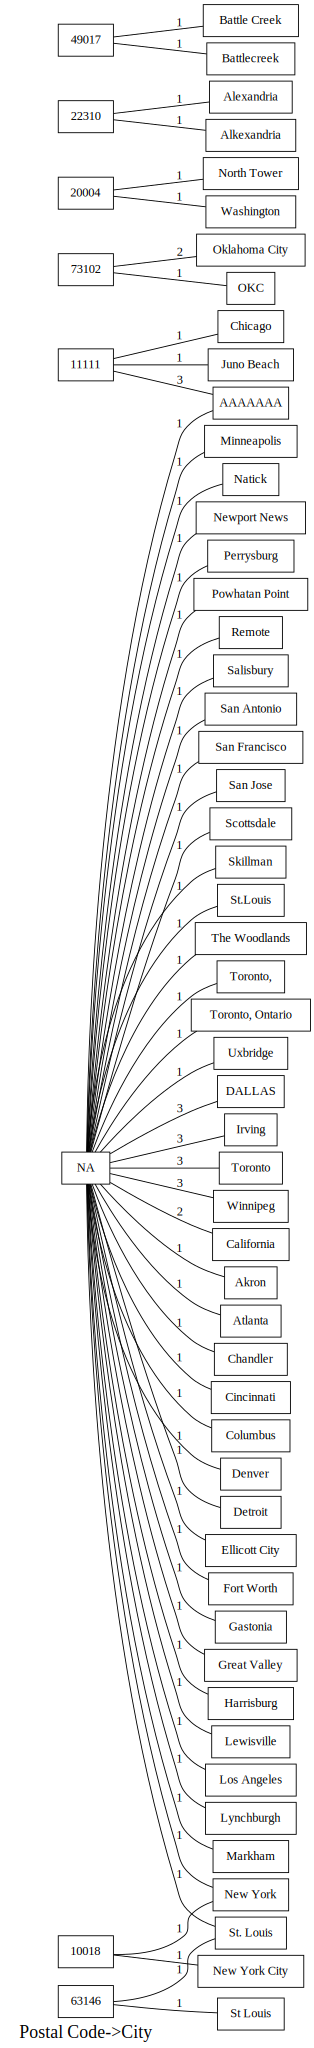

In [10]:
customer_state_df.plot_dependency_violations('Postal Code', 'City')

The plot of dependency violations shows values for *Postal Code* on the left hand side, and values for *City* on the right hand side. An edge connects a *Postal Code* on the left with a *City* on the right if there is a row that contains these two respective values. The edges are annotated with the count of such rows. For example, there are two rows with postal code 20004, one with CITY "North Tower" and one with CITY "Washington":

Moreover, the plot shows a few violations and many empty values.

In [11]:
customer_state_df['Postal Code'].isna().sum()

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 18, Finished, Available)

50

50 rows have NA for postal code. 

Next, drop rows with empty values. Then, find dependencies using the ``find_dependencies`` function. Notice the additional parameter ``verbose=1`` that offers a glimpse into the internal workings of SemPy:

In [12]:
customer_state_df2=customer_state_df.dropna()
customer_state_df2.find_dependencies(verbose=1)

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 19, Finished, Available)

State_x, StateCode: nunique 33, 33
Mapping size 33, dependency: True
State_x, State_y: nunique 33, 33
Mapping size 33, dependency: True

Dependencies for 10 columns 8 groups 275 rows, dropna=False, threshold=0.01
Region, Country/Region: cardinality shortcut: 0.0, 1.0
Region, Country/Region: conditional entropy 0.0, 1.0
Industry ID, Region: cached calculation 2.9751958829576504, 1.4548338980405395, 0.35134562333349867
Industry ID, Region: conditional entropy 1.103488274707041, 2.6238502596241515
Industry ID, Country/Region: cardinality shortcut: 0.0, 1.0
Industry ID, Country/Region: conditional entropy 0.0, 1.0
State_x, Industry ID: cached calculation 2.9883008304144907, 2.9751958829576504, 1.1575667522391768
State_x, Industry ID: conditional entropy 1.8176291307184735, 1.8307340781753139
State_x, Region: cached calculation 2.9883008304144907, 1.4548338980405395, 1.4548338980405395
State_x, Region: conditional entropy 0.0, 1.5334669323739512
State_x, Country/Region: indirectly dependent

Determinant                      Dependent  \
0                        Customer                           Name   
1                        Customer                    Postal Code   
2                        Customer                           City   
3                        Customer  [State_x, StateCode, State_y]   
4                        Customer                    Industry ID   
5                            Name                 Country/Region   
6                     Postal Code                 Country/Region   
7                            City                 Country/Region   
8   [State_x, StateCode, State_y]                         Region   
9                     Industry ID                 Country/Region   
10                         Region                 Country/Region   

    Conditional Entropy  Determinant Unique Count  Dependent Unique Count  \
0                   0.0                       275                     256   
1                   0.0                       275                     205   
2                   0.0                       275                     165   
3                   0.0                       275                      33   
4                   0.0                       275                      32   
5                   0.0                       256                       1   
6                   0.0                       205                       1   
7                   0.0                       165                       1   
8                   0.0                        33                       5   
9                   0.0                        32                       1   
10                  0.0                         5                       1   

    Determinant Null Count  Dependent Null Count  
0                        0                     0  
1                        0                     0  
2                        0                     0  
3                        0                     0  
4                        0                     0  
5                        0                     0  
6                        0                     0  
7                        0                     0  
8                        0                     0  
9                        0                     0  
10                       0                     0

The conditional entropy is 0.049. This value can be explained by the fact there are functional dependency violations. Before you fix the violations, raise the threshold on conditional entropy from the default value of `0.01` to `0.05`, just to see the dependencies. Lower thresholds result in less dependencies (higher selectivity).

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 20, Finished, Available)

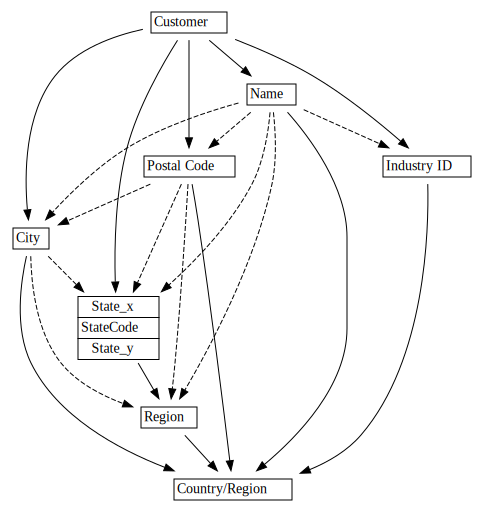

In [13]:
plot_dependency_metadata(customer_state_df2.find_dependencies(threshold=0.05))

If you apply domain knowledge of which entity determines values of other entities, this dependencies graph seems accurate. 

Now, explore more data quality issues that were detected. For example, *City* and *Region* are joined by a dashed arrow, which indicates that the dependency is only approximate. This could imply that there is a partial functional dependency.

In [14]:
customer_state_df.list_dependency_violations('City', 'Region')

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 21, Finished, Available)

City   Region  count
0        AAAAAAA    SOUTH      3
1        AAAAAAA      NaN      1
2  Downers Grove  CENTRAL      1
3  Downers Grove    NORTH      1
4        Fremont    SOUTH      1
5        Fremont     WEST      1
6       Uxbridge     EAST      1
7       Uxbridge      NaN      1

Take a closer look at each of the cases where a non-empty *Region* value causes a violation:

In [15]:
customer_state_df[customer_state_df.City=='Downers Grove']

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 22, Finished, Available)

Customer Country/Region               Name           City  Postal Code  \
66      10114             US  SNC Downers Grove  Downers Grove        60515   
249     50128             US  SNC Downers Grove  Downers Grove        60515   

    State_x  Industry ID StateCode   State_y   Region  
66       NE           30        NE  NEBRASKA  CENTRAL  
249      IL           30        IL  ILLINOIS    NORTH

Downers Grove definitely is a [city in Illinois](https://en.wikipedia.org/wiki/Downers_Grove,_Illinois), not Nebraska.

In [16]:
customer_state_df[customer_state_df.City=='Fremont']

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 23, Finished, Available)

Customer Country/Region             Name     City  Postal Code State_x  \
37     10036             US         Horn BPO  Fremont        94555      TX   
46     10060             US  Soneli Graphics  Fremont        94538      CA   

    Industry ID StateCode     State_y Region  
37           30        TX       TEXAS  SOUTH  
46           13        CA  CALIFORNIA   WEST

There is a city called [Fremont in California](https://en.wikipedia.org/wiki/Fremont,_California). However, for Texas, the search engine returns [Premont](https://en.wikipedia.org/wiki/Premont,_Texas), not Fremont!

It's also suspicious to see violations of "Name" and "Country/Region" depencency, as signified by the dotted line in the original graph of dependency violations (before dropping the rows with empty values).

In [17]:
customer_state_df.list_dependency_violations('Name', 'Country/Region')

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 24, Finished, Available)

Name Country/Region  count
0  SDI Design             CA      1
1  SDI Design             US      1

It appears that one customer, 'SDI Design' is present in two regions - United States and Canada. This may not be a semantic violation, but may just be an uncommon case. Still, it's worth taking a close look:

In [18]:
customer_state_df[customer_state_df.Name=='SDI Design']

StatementMeta(, fc14b6c0-dca9-4949-a887-6bf9f5f5e3bc, 25, Finished, Available)

Customer Country/Region        Name      City  Postal Code State_x  \
128     10203             US  SDI Design    Denver        80222      CO   
323     50233             CA  SDI Design  Winnipeg         <NA>      MB   

     Industry ID StateCode   State_y   Region  
128           15        CO  COLORADO  CENTRAL  
323           30       NaN       NaN      NaN

Further inspection shows that it's actually two different customers (from different industries) with the same name.

Exploratory data analysis is an exciting process, and so is data cleaning. There's always something that the data is hiding, depending on how you look at it, what you want to ask, and so on. Semantic Link provides you with new tools that you can use to achieve more with your data. 

## Next step

Try using the learned ways of detecting data quality issues on your data and get amazed with the discoveries!

## Related content

Check out other tutorials for Semantic Link / SemPy:
1. Clean Data with Functional Dependencies
1. Discover Relationships in SYNTHEA dataset Using Semantic Link
1. Discover Relationships in a PowerBI Dataset Using Semantic Link
1. Extract and Calculate PowerBI Measures from Jupyter Notebook